In [1]:
!date

Tue May 14 11:04:12 PDT 2024


In [2]:
%load_ext autoreload
%load_ext line_profiler

In [3]:
import logging
logging.basicConfig(level=logging.INFO, force=True)

In [4]:
import os as _os
_os.chdir(_os.environ['PROJECT_ROOT'])

In [5]:
import graph_tool as gt
import graph_tool.draw
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from contextlib import contextmanager
import xarray as xr
from itertools import product
from tqdm import tqdm
from itertools import chain
from graph_tool.util import find_edge
import scipy as sp

import strainzip as sz
from strainzip.pandas_util import idxwhere
import strainzip.app.assemble

In [6]:
# Plotting parameters

length_bins = np.logspace(0, 6.5, num=51)
depth_bins = np.logspace(-1, 4, num=51)

draw_graphs = True
run_number = 30  # Label for output files/figures

In [7]:
group = 'xjin_test6'

with open(f'data/group/{group}/r.proc.kmtricks-k111-m3-r2.ggcat-denovo.fn') as f:
    _, unitig_to_sequence = sz.io.load_graph_and_sequences_from_linked_fasta(f, 111, sz.io.ggcat_header_tokenizer)

In [8]:
final_graph = sz.io.load_graph(f'data/group/{group}/r.proc.kmtricks-k111-m3-r2.ggcat-denovo.notips.smoothed.deconvolve-log-10.sz')
final_results = sz.results.extract_vertex_data(final_graph)
# Assembly only necessary for saving sequences.
#.assign(assembly=lambda d: d.segments.apply(sz.results.assemble_overlapping_unitigs, unitig_to_sequence=unitig_to_sequence, k=final_graph.gp['kmer_length']))
sz.stats.depth_weighted_mean_tig_length(final_graph)

PropertyArray(1321.3055509)

In [9]:
original_graph = sz.io.load_graph(f'data/group/{group}/r.proc.kmtricks-k111-m3-r2.ggcat-denovo.notips-unpressed.sz')
original_results = sz.results.extract_vertex_data(original_graph)
sz.stats.depth_weighted_mean_tig_length(original_graph)

PropertyArray(95.43608636)

In [10]:
nounzip_graph = sz.io.load_graph(f'data/group/{group}/r.proc.kmtricks-k111-m3-r2.ggcat-denovo.notips.sz')
nounzip_results = sz.results.extract_vertex_data(nounzip_graph)
sz.stats.depth_weighted_mean_tig_length(nounzip_graph)

PropertyArray(342.54299055)

In [11]:
nounzip_smoothed_graph = sz.io.load_graph(f'data/group/{group}/r.proc.kmtricks-k111-m3-r2.ggcat-denovo.notips.smoothed.sz')
nounzip_smoothed_results = sz.results.extract_vertex_data(nounzip_smoothed_graph)
sz.stats.depth_weighted_mean_tig_length(nounzip_smoothed_graph)

PropertyArray(324.40077732)

In [12]:
alt1_graph = sz.io.load_graph(f'data/group/{group}/r.proc.kmtricks-k111-m3-r2.ggcat-denovo.notips.smoothed.deconvolve-log-10-5.sz')
alt1_results = sz.results.extract_vertex_data(alt1_graph)
sz.stats.depth_weighted_mean_tig_length(alt1_graph)

PropertyArray(367.49545009)

In [13]:
alt2_graph = sz.io.load_graph(f'data/group/{group}/r.proc.kmtricks-k111-m3-r2.ggcat-denovo.notips.smoothed.deconvolve-log-10-5.deconvolve-log-10-5.sz')
alt2_results = sz.results.extract_vertex_data(alt2_graph)
sz.stats.depth_weighted_mean_tig_length(alt2_graph)

PropertyArray(396.51422033)

In [14]:
alt3_graph = sz.io.load_graph(f'data/group/{group}/r.proc.kmtricks-k111-m3-r2.ggcat-denovo.notips.smoothed.deconvolve-log-10-5.deconvolve-log-10-5.deconvolve-log-10-5.sz')
alt3_results = sz.results.extract_vertex_data(alt3_graph)
sz.stats.depth_weighted_mean_tig_length(alt3_graph)

PropertyArray(424.27276298)

In [15]:
alt4_graph = sz.io.load_graph(f'data/group/{group}/r.proc.kmtricks-k111-m3-r2.ggcat-denovo.notips.smoothed.deconvolve-log-10-5.deconvolve-log-10-5.deconvolve-log-10-5.deconvolve-log-10-5.sz')
alt4_results = sz.results.extract_vertex_data(alt4_graph)
sz.stats.depth_weighted_mean_tig_length(alt4_graph)

PropertyArray(448.29036086)

In [16]:
alt5_graph = sz.io.load_graph(f'data/group/{group}/r.proc.kmtricks-k111-m3-r2.ggcat-denovo.notips.smoothed.deconvolve-log-10-5.deconvolve-log-10-5.deconvolve-log-10-5.deconvolve-log-10-5.deconvolve-log-10-5.sz')
alt5_results = sz.results.extract_vertex_data(alt5_graph)
sz.stats.depth_weighted_mean_tig_length(alt5_graph)

PropertyArray(473.29289092)

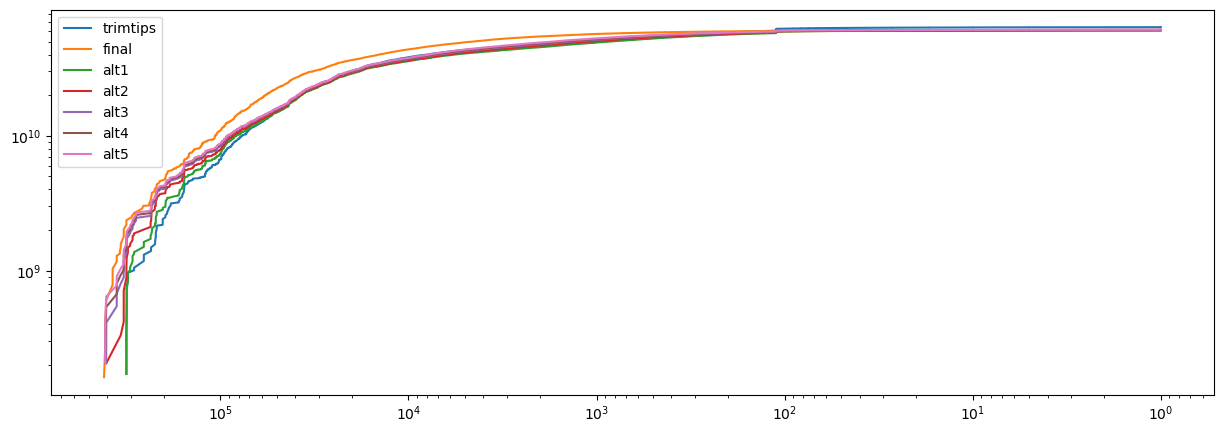

In [17]:
# Overall, we get about 2x as much long sequence depth (distribution of tig lengths of assigned kmers)

fig, ax = plt.subplots(figsize=(15, 5))

for _label, _results in {
    # 'unitigs': original_results,
    'trimtips': nounzip_results,
    'final': final_results,
    # 'norefs': norefs_results,
    'alt1': alt1_results,
    'alt2': alt2_results,
    'alt3': alt3_results,
    'alt4': alt4_results,
    'alt5': alt5_results,
}.items():
    d = _results.sort_values('length', ascending=False).assign(length_x_depth=lambda x: x.total_depth * x.length, length_x_depth_cumsum=lambda x: x.length_x_depth.cumsum())
    ax.plot(d.length, d.length_x_depth_cumsum, label=_label)

ax.set_yscale('log')
ax.set_xscale('log')

ax.legend()
ax.invert_xaxis()

In [18]:
vertex_unitig_matrix = final_results.segments.explode().str[:-1].astype(int).reset_index().rename(columns={'segments': 'unitig'}).value_counts().rename('tally').reset_index().sort_values(['vertex', 'unitig'])
idx_to_unitig = pd.Series(vertex_unitig_matrix.unitig.unique(), name='unitig')
unitig_to_idx = idx_to_unitig.reset_index().set_index('unitig').squeeze()
vertex_unitig_matrix = vertex_unitig_matrix.assign(unitig_index=lambda x: x.unitig.map(unitig_to_idx))

sparse_vertex_unitig_matrix = sp.sparse.csr_matrix((np.ones(len(vertex_unitig_matrix)), (vertex_unitig_matrix.vertex, vertex_unitig_matrix.unitig_index)))

vertex_depth = pd.DataFrame(final_graph.vp['depth'].get_2d_array(pos=range(final_graph.gp['num_samples'])), columns=final_graph.get_vertices())

expect_unitig_depth = pd.DataFrame((vertex_depth.values @ sparse_vertex_unitig_matrix).T).rename(idx_to_unitig)

In [19]:
unitig_depth_table = xr.load_dataarray(f'data/group/{group}/r.proc.kmtricks-k111-m3-r2.ggcat-denovo.unitig_depth.nc')

PearsonRResult(statistic=0.9581614398178969, pvalue=0.0)


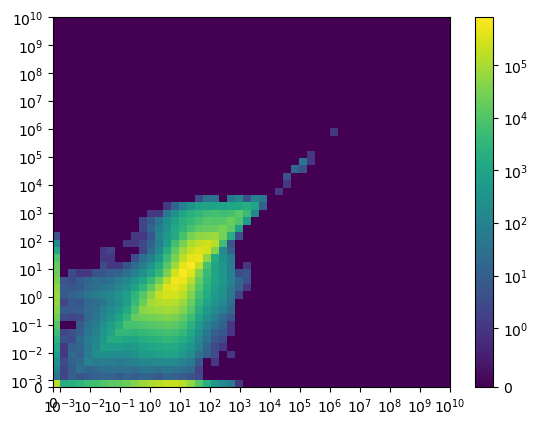

In [20]:
pred = expect_unitig_depth
obs = unitig_depth_table.sel(unitig=expect_unitig_depth.index)

bins = np.concatenate([[0], np.logspace(-3, 10, num=50)])

plt.hist2d(pred.values.ravel(), obs.values.ravel(), bins=bins, norm=mpl.colors.SymLogNorm(linthresh=1))
plt.xscale('symlog', linthresh=1e-3, linscale=0.2)
plt.yscale('symlog', linthresh=1e-3, linscale=0.2)
plt.colorbar()

print(sp.stats.pearsonr(pred.values.ravel(), obs.values.ravel()))

In [21]:
vertex_unitig_matrix.sort_values('tally', ascending=False).head()

,vertex,unitig,tally,unitig_index
0,59041,2273632,9,193884
1,59041,1899526,9,193878
2,59041,2227583,9,193883
3,59041,1622348,9,193874
4,59041,1569445,9,193873


In [22]:
final_results.sort_values(['num_segments'], ascending=False).head(300)

,in_neighbors,out_neighbors,length,total_depth,segments,num_segments,num_in_neighbors,num_out_neighbors
vertex,,,,,,,,
56035,(30225),(29760),27268,184.000067,"(2196396-, 1238-, 1309-, 1370-, 1314-, 1351+, ...",2244,1,1
56039,(30225),(29760),27268,228.466615,"(2196396-, 1238-, 1309-, 1370-, 1314-, 1351+, ...",2239,1,1
46392,(30225),(29760),27268,276.131926,"(2197532-, 1881005-, 1269989-, 1270016-, 12700...",2207,1,1
55045,(18788),(5017),125592,315.300688,"(382222+, 382213+, 382133-, 382142-, 382157-, ...",1972,1,1
59040,(13595),(18762),125592,317.403552,"(1990330-, 1927738+, 2007371-, 365079+, 183829...",1970,1,1
...,...,...,...,...,...,...,...,...
60796,(),(10525),157306,213.849068,"(46324-, 46349+, 46354+, 46241+, 2186108-, 113...",190,0,1
48497,(5039),(),107575,327.741938,"(1508360+, 656601+, 1509234+, 261791+, 1654548...",189,1,0
60751,"(59272, 49141)",(10525),157535,217.416779,"(1480744-, 46354+, 46241+, 2186108-, 1136874-,...",189,2,1


In [23]:
final_results.segments.explode().value_counts().head(20)

segments
1218076+    12
2155928-    10
2273632+    10
1622348-    10
1524736+    10
1990110+    10
2227583-    10
1712048+    10
2227572-    10
1899526+    10
1898839+    10
1246227-    10
1246326+    10
1641091-    10
1938741-    10
1368911-    10
1368910+    10
1569445-    10
1218036-    10
1368879-    10
Name: count, dtype: int64

In [83]:
# Use this to find tigs of interest.

final_results.loc[sz.results.iter_find_vertices_with_any_segment(final_graph, ['112641+'])]

,in_neighbors,out_neighbors,length,total_depth,segments,num_segments,num_in_neighbors,num_out_neighbors
vertex,,,,,,,,
51524,(25943),(26023),38487,798.070446,"(1248661+, 1248669-, 2274378-, 1765312+, 44496...",570,1,1
52772,(25943),(26023),38487,136.548148,"(1248661+, 1248669-, 2274378-, 1765312+, 44496...",564,1,1
52828,(25943),(26023),38487,273.188047,"(1248661+, 1248669-, 2274378-, 1765312+, 44496...",567,1,1
55003,(3369),(26023),66052,1142.050802,"(2192574+, 703145-, 1460625+, 2325544+, 217387...",898,1,1
55004,(3369),(26023),66052,495.142381,"(2192574+, 703145-, 1460625+, 2325544+, 217387...",898,1,1


In [25]:
# This part is slow. Don't recalculate every time.
backlinked_original_graph = sz.topology.backlinked_graph(original_graph)

In [84]:
focal_path = 55004
radius = 100

related_paths = list(sz.results.iter_find_vertices_with_any_segment(final_graph, final_results.loc[focal_path].segments))
focal_segments = list(set(chain(*final_results.loc[related_paths].segments)))
print(len(related_paths), len(focal_segments))

original_graph_core_vertices = list(sz.results.iter_find_vertices_with_any_segment(original_graph, focal_segments))
original_graph_distance_to_core = sz.topology.get_shortest_distance(original_graph, original_graph_core_vertices, original_graph.vp['length'], max_length=radius, backlinked=backlinked_original_graph, )
in_neighborhood = original_graph.new_vertex_property('bool', vals=original_graph_distance_to_core.a < radius - 1)

neighborhood_graph = gt.GraphView(original_graph, vfilt=in_neighborhood)
print(neighborhood_graph)

# outpath = f'fig/run-{run_number}/final_paths.neighborhood-{focal_path}.fn'
# with open(outpath, 'w') as f:
#     for path, d1 in final_results.loc[related_paths].iterrows():
#         print(f">{path}\n{d1.assembly}", file=f)
# print(outpath)

5 1480


/usr/local/Caskroom/miniconda/base/envs/strainzip/lib/python3.12/site-packages/graph_tool/__init__.py:2004: SyntaxWarning: invalid escape sequence '\m'
  """Return the edge from vertex ``s`` to ``t``, if it exists. If

KeyboardInterrupt



In [82]:
sz.draw.update_xypositions(neighborhood_graph)

vertex_color = neighborhood_graph.new_vertex_property('float', vals=np.log(sz.results.total_depth_property(neighborhood_graph).a + 1))

for path in related_paths:
    original_graph_vertices = list(sz.results.iter_find_vertices_with_any_segment(original_graph, final_results.loc[path].segments))
    print(len(original_graph_vertices))
    in_path = original_graph.new_vertex_property('bool', val=False)
    in_path.a[original_graph_vertices] = 1
    outpath = f'fig/run-{run_number}/neighborhood-{focal_path}.final.neighbor-{path}.pdf'
    sz.draw.draw_graph(
        neighborhood_graph,
        vertex_text=neighborhood_graph.vp['sequence'],
        vertex_halo=in_path,
        vertex_font_size=5,
        vertex_fill_color=vertex_color,
        output=outpath,
        vcmap=(mpl.cm.magma, 1),
        output_size=(500, 500),
    )
    print(outpath)

final_results.loc[related_paths]

6
fig/run-30/neighborhood-20232.final.neighbor-20232.pdf


,in_neighbors,out_neighbors,length,total_depth,segments,num_segments,num_in_neighbors,num_out_neighbors
vertex,,,,,,,,
20232,(39949),"(7986, 18830)",6,69762.158415,"(1191376-, 1191388-, 1191387-, 1191226-, 11914...",6,1,2


In [28]:
# Instead of alternative paths in the final graph, try alternative paths in a previous iteration:

previous_graph = alt1_graph
previous_results = alt1_results
previous_paths = list(sz.results.iter_find_vertices_with_any_segment(previous_graph, final_results.loc[focal_path].segments))

for path in previous_paths:
    original_graph_vertices = list(sz.results.iter_find_vertices_with_any_segment(original_graph, previous_results.loc[path].segments))
    print(len(original_graph_vertices))
    in_path = original_graph.new_vertex_property('bool', val=False)
    in_path.a[original_graph_vertices] = 1
    outpath = f'fig/run-{run_number}/neighborhood-{focal_path}.previous.overlapping-{path}.pdf'
    sz.draw.draw_graph(
        neighborhood_graph,
        vertex_text=neighborhood_graph.vp['sequence'],
        vertex_halo=in_path,
        vertex_font_size=5,
        vertex_fill_color=vertex_color,
        output=outpath,
        vcmap=(mpl.cm.magma, 1),
        output_size=(500, 500),
    )
    print(outpath)

previous_results.loc[previous_paths]

1
fig/run-30/neighborhood-59163.previous.overlapping-17229.pdf
1
fig/run-30/neighborhood-59163.previous.overlapping-29520.pdf
1
fig/run-30/neighborhood-59163.previous.overlapping-42980.pdf
1
fig/run-30/neighborhood-59163.previous.overlapping-87455.pdf
1
fig/run-30/neighborhood-59163.previous.overlapping-114510.pdf
6
fig/run-30/neighborhood-59163.previous.overlapping-132592.pdf
2
fig/run-30/neighborhood-59163.previous.overlapping-170501.pdf
2
fig/run-30/neighborhood-59163.previous.overlapping-173032.pdf
9
fig/run-30/neighborhood-59163.previous.overlapping-177985.pdf
8
fig/run-30/neighborhood-59163.previous.overlapping-178878.pdf
6
fig/run-30/neighborhood-59163.previous.overlapping-179230.pdf
6
fig/run-30/neighborhood-59163.previous.overlapping-179586.pdf


,in_neighbors,out_neighbors,length,total_depth,segments,num_segments,num_in_neighbors,num_out_neighbors
vertex,,,,,,,,
17229,"(179586, 179230)","(29520, 118739)",118,328.737606,"(1851590+,)",1,2,2
29520,(17229),(132592),111,207.802332,"(1841164+,)",1,1,1
42980,"(66080, 114510)","(177985, 178878)",283,450.993828,"(1509842-,)",1,2,2
87455,"(177985, 174718)","(87456, 170501)",33,474.185956,"(1646631+,)",1,2,2
114510,(132592),(42980),111,156.995571,"(1443374+,)",1,1,1
132592,"(29520, 118739)","(66080, 114510)",7531,358.399232,"(1146037-, 1685610-, 299414-, 1684961-, 175700...",6,2,2
170501,(87455),(21178),431,210.196978,"(1460451-, 1460767+)",2,1,1
173032,(96152),(21178),480,264.261781,"(1953855-, 1460767+)",2,1,1
177985,(42980),(87455),14156,280.200524,"(2009877-, 2202682-, 2202163+, 1840679+, 18413...",9,1,1


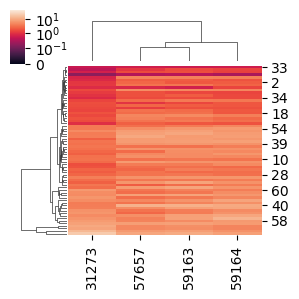

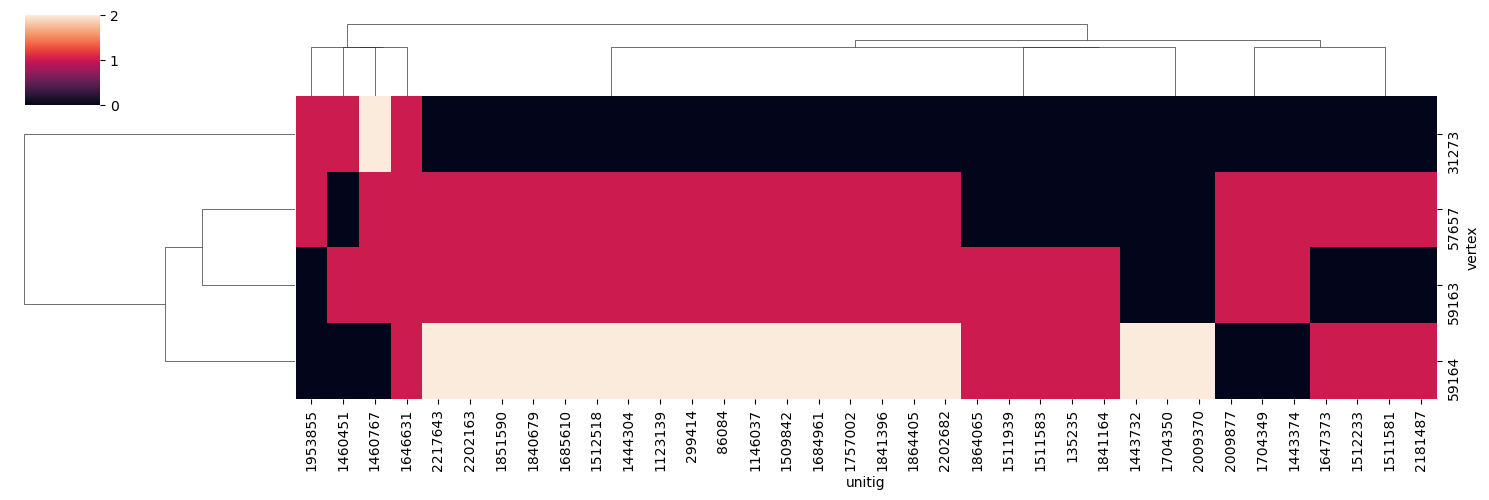

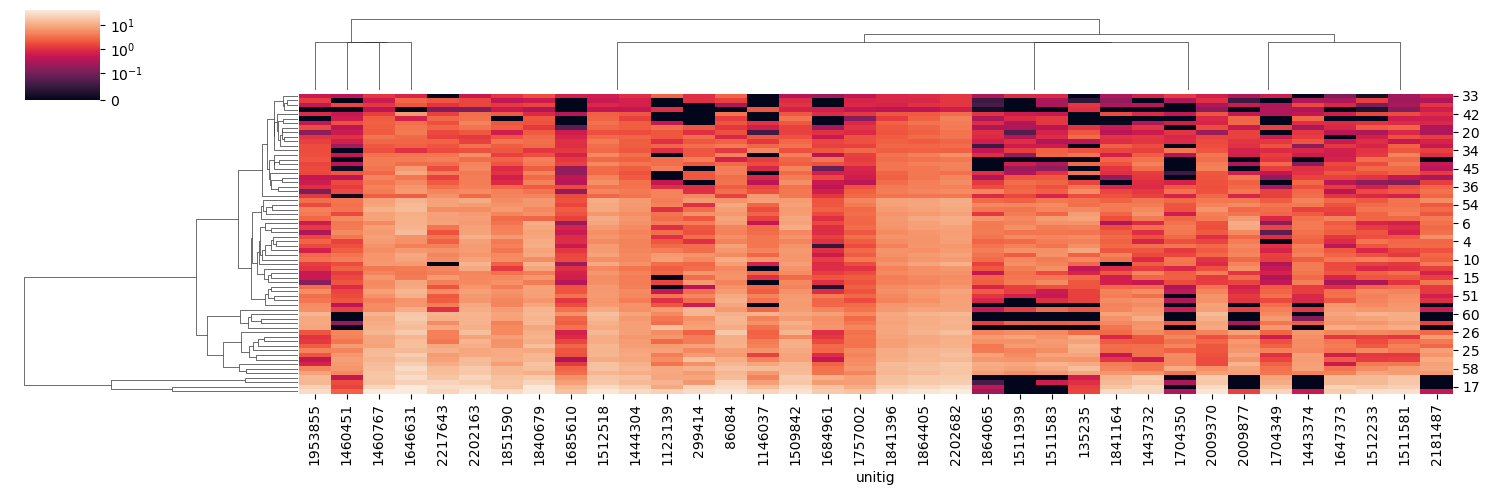

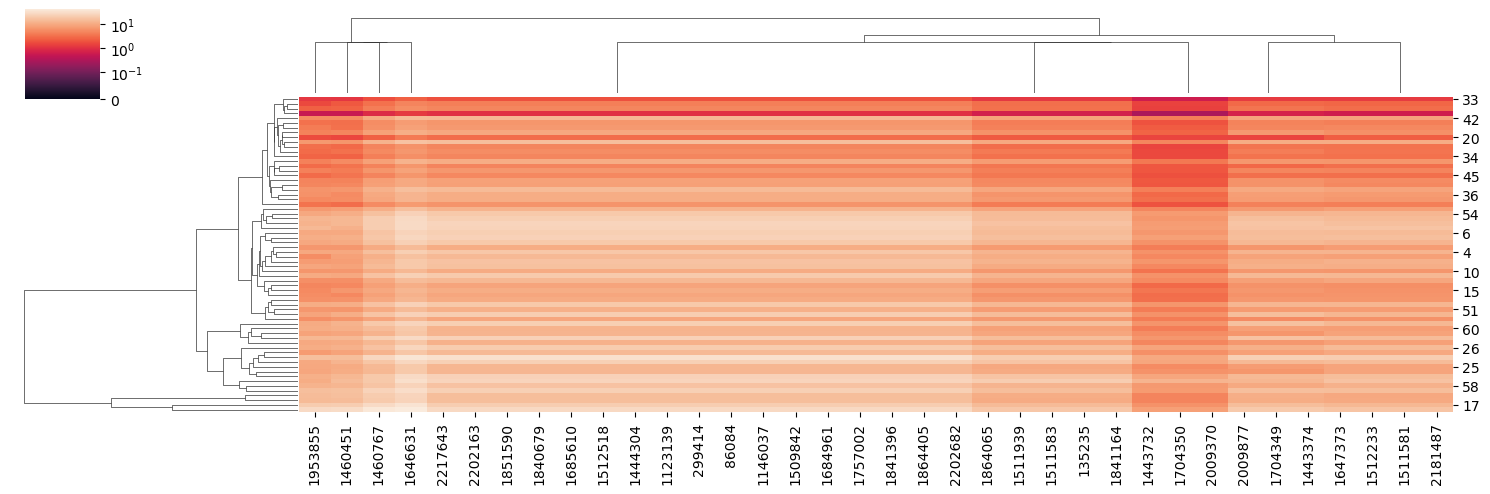

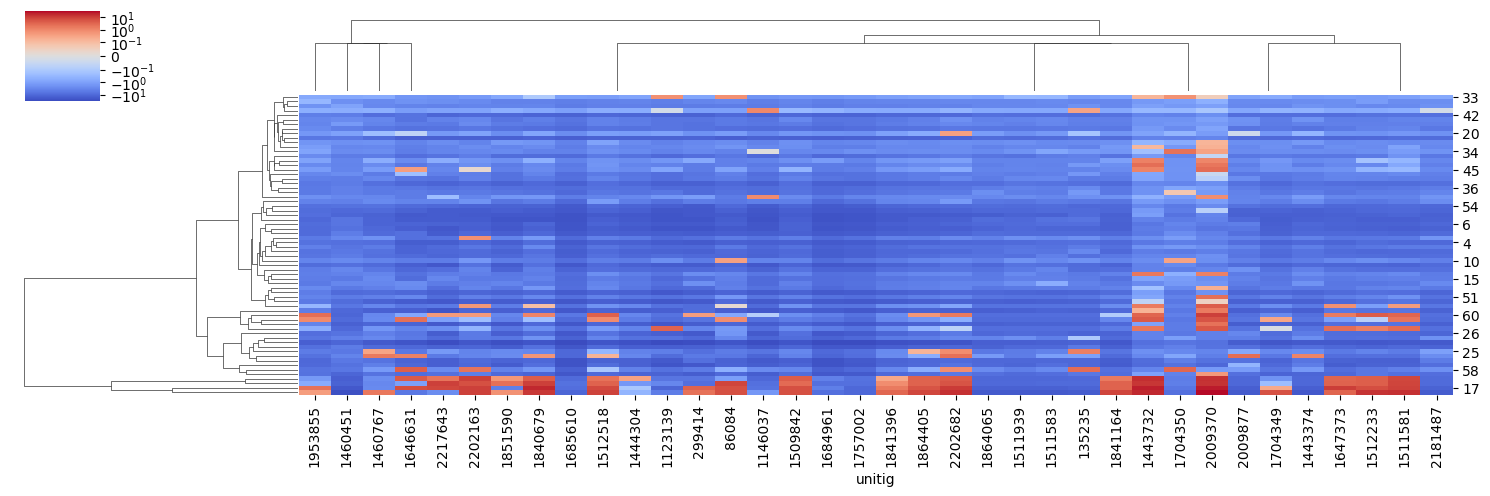

In [30]:
focal_unitigs = np.unique([int(s[:-1]) for s in focal_segments])
obs_unitig_depth = unitig_depth_table.sel(unitig=focal_unitigs).T.to_pandas().reset_index(drop=True)
path_membership = vertex_unitig_matrix[lambda x: x.vertex.isin(related_paths)].set_index(['vertex', 'unitig']).tally.unstack(fill_value=0)
est_path_depth = vertex_depth[related_paths]
pred_unitig_depth = expect_unitig_depth.loc[focal_unitigs].T
resid_unitig_depth = obs_unitig_depth - pred_unitig_depth

max_obs = obs_unitig_depth.max().max()
max_resid = np.abs(resid_unitig_depth).max().max()

unitig_linkage = sp.cluster.hierarchy.linkage(path_membership.T, metric='euclidean', method='average', optimal_ordering=True)
path_linkage = sp.cluster.hierarchy.linkage(est_path_depth.T, metric='euclidean', method='average', optimal_ordering=True)
sample_linkage = sp.cluster.hierarchy.linkage(obs_unitig_depth, metric='euclidean', method='average', optimal_ordering=True)

sns.clustermap(est_path_depth, row_linkage=sample_linkage, col_linkage=path_linkage, figsize=(3, 3), norm=mpl.colors.SymLogNorm(1e-1, vmin=0, vmax=max_obs))
sns.clustermap(path_membership, row_linkage=path_linkage, col_linkage=unitig_linkage, figsize=(15, 5), xticklabels=1)
sns.clustermap(obs_unitig_depth, row_linkage=sample_linkage, col_linkage=unitig_linkage, figsize=(15, 5), norm=mpl.colors.SymLogNorm(1e-1, vmin=0, vmax=max_obs), xticklabels=1)
sns.clustermap(pred_unitig_depth, row_linkage=sample_linkage, col_linkage=unitig_linkage, figsize=(15, 5), norm=mpl.colors.SymLogNorm(1e-1, vmin=0, vmax=max_obs), xticklabels=1)
sns.clustermap(resid_unitig_depth, row_linkage=sample_linkage, col_linkage=unitig_linkage, figsize=(15, 5), norm=mpl.colors.SymLogNorm(1e-1, vmin=-max_resid, vmax=max_resid), cmap='coolwarm', xticklabels=1)

In [79]:
d.sort_values()

10599    0.000000e+00
25148    0.000000e+00
12252    0.000000e+00
25146    0.000000e+00
12254    0.000000e+00
             ...     
20382    6.862329e+04
15186    6.927370e+04
20232    6.976216e+04
1967     3.975498e+06
3220     3.975498e+06
Length: 60907, dtype: float64

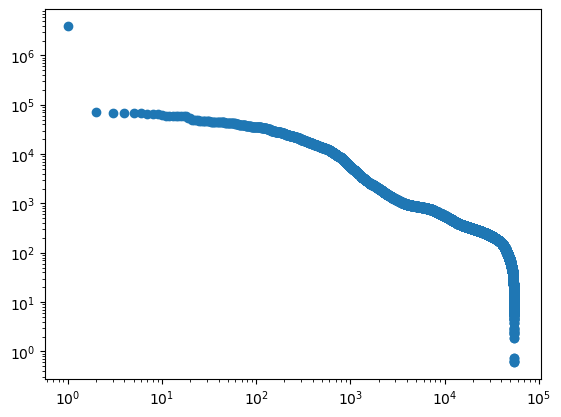

In [78]:
d = vertex_depth.sum()

xx = np.arange(len(d))
yy = d.sort_values(ascending=False).values
plt.scatter(xx, yy)
plt.yscale('log')
plt.xscale('log')

In [68]:
pca.pc0.sort_values()

8           -71.243767
15          -71.243767
63          -71.243767
25075       -71.243767
20237       -71.243767
             ...      
19953      4817.989621
15186      4863.818972
20232      4900.125823
3220     762743.712118
1967     762743.712118
Name: pc0, Length: 60907, dtype: float64

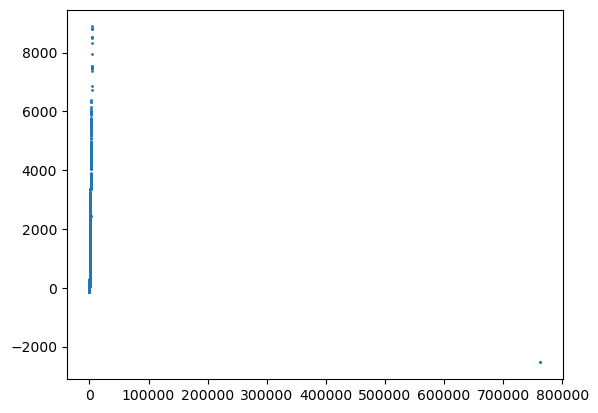

In [54]:
from sklearn.decomposition import PCA

pca = pd.DataFrame(PCA().fit_transform(vertex_depth.T), index=vertex_depth.T.index).rename(columns=lambda i: f'pc{i}')
plt.scatter('pc0', 'pc1', data=pca, s=1)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1).fit(vertex_depth.T)

In [ ]:
agg

In [254]:
pca.shape

(60907, 66)

In [24]:
# Why is the estimated depth of the deconvolved vertex 53765 equal to 53766, despite one taking the low-depth portions of the path?
# I'll check depths on the trimtips graph, where I'll look for segments composing some of the junctions that differentiate
# the two paths:
# 875067+ (which goes into the low depth segment: 1730538+ as well as the high-depth segment 875009)

In [73]:
d = nounzip_results[lambda x: x.apply(lambda x: ('263944+' in x.segments), axis=1)]
print(d.segments.values)
d

[('1498949-', '1780562-', '1094157+', '1094165-', '1780563+', '1714198-', '368655-', '1715012+', '1517477+', '1643805+', '263944+')]


,in_neighbors,out_neighbors,length,total_depth,segments,num_segments,num_in_neighbors,num_out_neighbors
vertex,,,,,,,,
198370,"(218325, 61623)","(201758, 125495)",476,2544.586134,"(1498949-, 1780562-, 1094157+, 1094165-, 17805...",11,2,2


In [26]:
nounzip_results.loc[[218325, 61623, 198370, 201758, 125495]]

,in_neighbors,out_neighbors,length,total_depth,segments,num_segments,num_in_neighbors,num_out_neighbors
vertex,,,,,,,,
218325,(198708),(198370),111,2259.639640,"(645194-, 2172939+, 81783-)",3,1,1
61623,(198708),(198370),111,205.684685,"(1498957+,)",1,1,1
198370,"(218325, 61623)","(201758, 125495)",476,2544.586134,"(1498949-, 1780562-, 1094157+, 1094165-, 17805...",11,2,2
201758,(198370),(199459),111,2241.135135,"(263949-, 1676715+, 286514-, 286311-)",4,1,1
125495,(198370),(199459),111,85.603604,"(1643758-,)",1,1,1


In [27]:
sample_idx = 20

In [28]:
_depth = gt.ungroup_vector_property(nounzip_graph.vp['depth'], pos=[sample_idx])[0]
_depth.a[[218325, 61623, 198370, 201758, 125495]]

PropertyArray([ 9.20720721,  0.92792793, 12.5987395 , 12.28828829,
                0.        ])

In [29]:
_flow, _hist = sz.flow.estimate_flow(nounzip_graph, _depth, nounzip_graph.vp['length'])
_flow[(218325, 198370)], _flow[(61623, 198370)], _flow[(198370, 201758)], _flow[(198370, 125495)]

(11.022045586853519,
 1.110833459143074,
 12.540033975263992,
 9.628626362327202e-08)

In [30]:
_depth_smoothed = gt.ungroup_vector_property(nounzip_smoothed_graph.vp['depth'], pos=[sample_idx])[0]
_depth_smoothed.a[[218325, 61623, 198370, 201758, 125495]]

PropertyArray([1.09056886e+01, 1.09919553e+00, 1.24507089e+01,
               1.31135234e+01, 1.58566832e-04])

In [31]:
%%time
# NOTE: Only run this if you want to examine deconvolutions

from strainzip.flow import estimate_all_flows

flow = estimate_all_flows(nounzip_smoothed_graph)
nounzip_smoothed_graph.ep['flow'] = flow

CPU times: user 2min 3s, sys: 3.97 s, total: 2min 7s
Wall time: 2min 9s


In [ ]:
# TODO:


# Figure out why 427403+ didn't deconvolve


# # Find the in-neighbor for 537322+
# # I assume it's part of a long contig.
# # Set up and look at the results of deconvolving this node
# # (it's trivial to pick paths; the part that's failing is the depth estimation.
# # What I expect is for the observed depth of the long unitig to be approximately the sum of the observed depth of the 537322+ and the 537318+ vertices.
# # I also expect the flows to reflect this
# # I then expect the deconvolution of each node to be
# 
# # Repeat this process for the out node of 537318+
# # Consider what happens when both nodes deconvolve simultaneously.

In [ ]:
# FIXME: Match up graphs and flows

In [34]:
j = 198732

condition_thresh = 1e6
score_margin_thresh = 10

_, in_neighbors, in_flows, out_neighbors, out_flows = list(
    sz.app.assemble._iter_junction_deconvolution_data(
        [j], nounzip_smoothed_graph, nounzip_smoothed_graph.ep['flow'], max_paths=1000
    )
)[0]

n, m = len(in_neighbors), len(out_neighbors)
fit, paths, named_paths, score_margin = sz.deconvolution.deconvolve_junction(
    in_neighbors,
    in_flows,
    out_neighbors,
    out_flows,
    # model=sz.depth_model2.SoftPlusNormal(maxiter=500),
    # model=sz.depth_model3.SoftPlusNormalPooledSigma(),
    # model=sz.depth_model4.SoftPlusStudentsT(),
    model=sz.depth_model.LogPlusAlphaLogNormal(alpha=1.0, maxiter=500),
    forward_stop=-100,
    backward_stop=0,
    verbose=True,
)

X, y, labels = sz.deconvolution.formulate_path_deconvolution(in_flows, out_flows)

print()
print(f"{n} x {m}")
print(f"score_margin={score_margin}")
print(f"completeness={X[:, paths].sum(1)}")
print(f"minimalism={len(paths)}")
print(f"condition={np.linalg.cond(fit.hessian_beta)}")

fim = np.linalg.inv(fit.hessian_beta)
stderr = np.diag(fim).reshape(fit.beta.shape)

(3,) -1600.265
(0, 3) -1365.4507
(0, 1, 3) 129.81982
(0, 1, 2, 3) -192.8794
(1, 2, 3) 527.61523
(2, 3) -1788.7206

2 x 2
score_margin=397.79541015625
completeness=[1 2 1 2]
minimalism=3
condition=2289041.25


<Axes: >

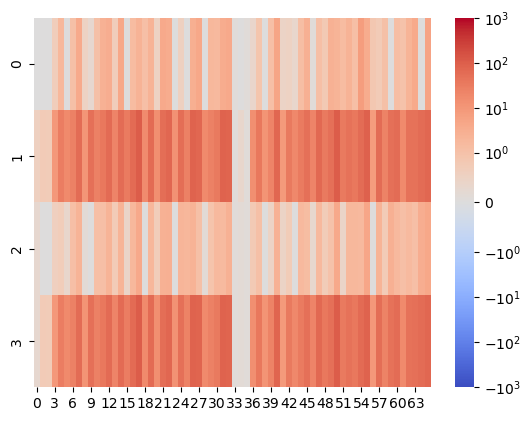

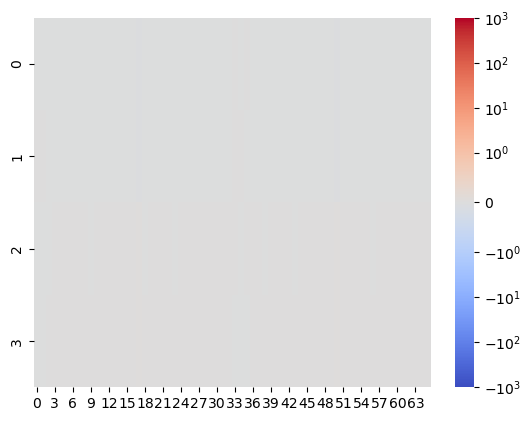

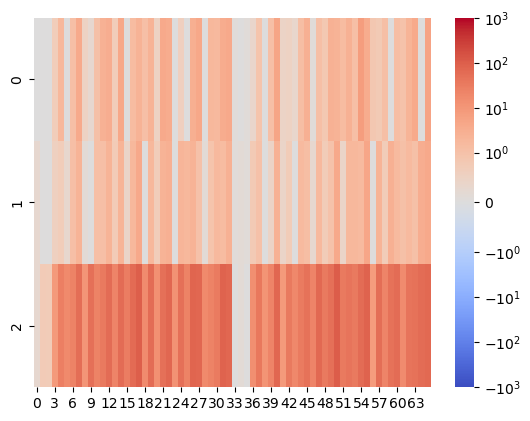

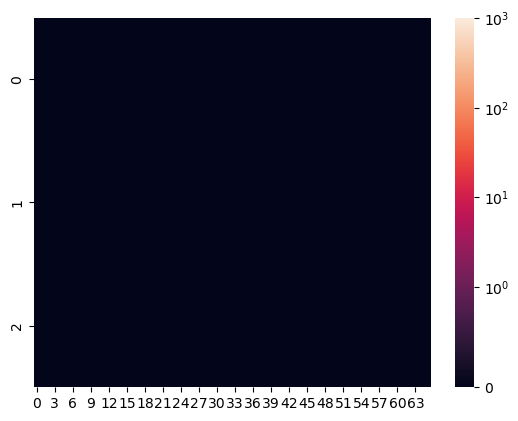

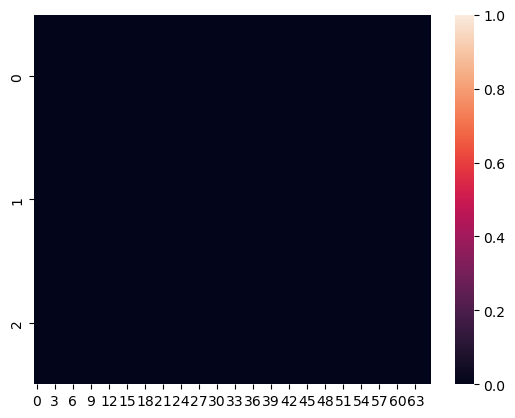

In [207]:
fig = plt.figure()
sns.heatmap(fit.y, norm=mpl.colors.SymLogNorm(1, vmin=-1e3, vmax=1e3), cmap='coolwarm')

fig = plt.figure()
sns.heatmap(fit.residual, norm=mpl.colors.SymLogNorm(1, vmin=-1e3, vmax=1e3), cmap='coolwarm')

fig = plt.figure()
sns.heatmap(fit.beta, norm=mpl.colors.SymLogNorm(1, vmin=-1e3, vmax=1e3), cmap='coolwarm')

fig = plt.figure()
sns.heatmap(stderr, norm=mpl.colors.SymLogNorm(1, vmin=0, vmax=1e3))

fig = plt.figure()
sns.heatmap((stderr) / (fit.beta + 1), norm=mpl.colors.PowerNorm(1, vmin=0, vmax=1))

<Axes: >

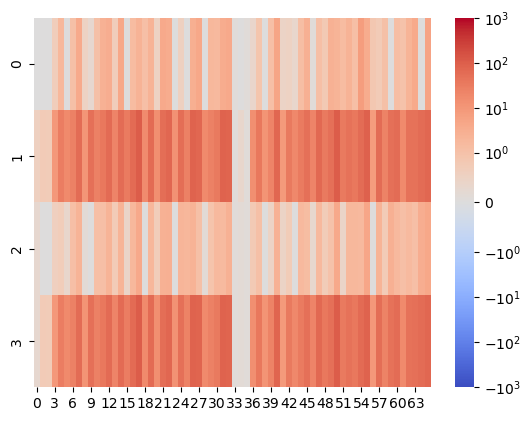

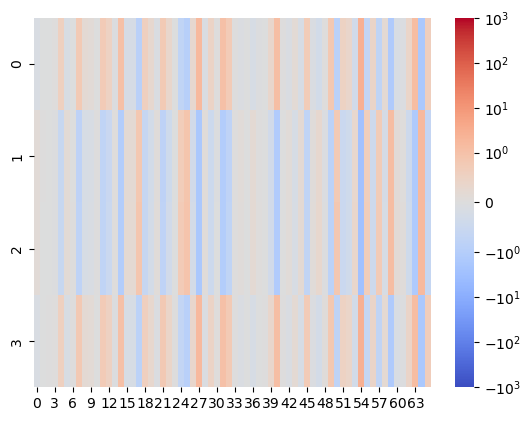

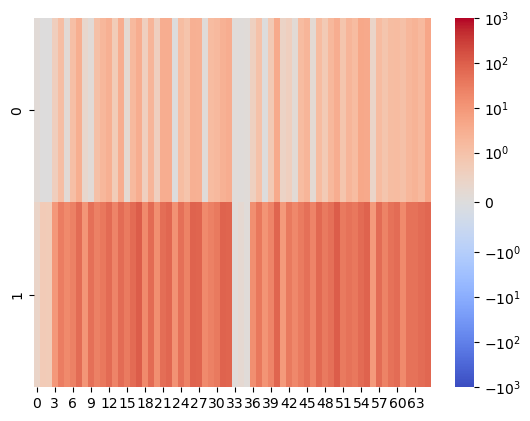

In [209]:
fit2 = sz.depth_model2.SoftPlusNormal().fit(y, X[:,[0, 3]])

fig = plt.figure()
sns.heatmap(fit2.y, norm=mpl.colors.SymLogNorm(1, vmin=-1e3, vmax=1e3), cmap='coolwarm')

fig = plt.figure()
sns.heatmap(fit2.residual, norm=mpl.colors.SymLogNorm(1, vmin=-1e3, vmax=1e3), cmap='coolwarm')

fig = plt.figure()
sns.heatmap(fit2.beta, norm=mpl.colors.SymLogNorm(1, vmin=-1e3, vmax=1e3), cmap='coolwarm')

In [187]:
%autoreload

In [170]:
import strainzip.depth_model4

In [189]:
for paths in [(1, 2, 3), (0, 1, 2, 3), (3,), (0, 3)]:
    f = sz.depth_model4.SoftPlusStudentsT().fit(y, X[:, paths])
    print(sz.depth_model4.loglik(f.beta, f.sigma, f.df, f.y, f.X), f.score)

-950.78357 -2431.5671
-913.2395 -2488.479
-973.9667 -2213.9333
-1016.5044 -2431.0088


In [184]:
from jax.scipy.stats import norm as JaxNormalDistribution

JaxNormalDistribution

Type:        module
String form: <module 'jax.scipy.stats.norm' from '/usr/local/Caskroom/miniconda/base/envs/strainzip/lib/python3.12/site-packages/jax/scipy/stats/norm.py'>
File:        /usr/local/Caskroom/miniconda/base/envs/strainzip/lib/python3.12/site-packages/jax/scipy/stats/norm.py
Docstring:   <no docstring>

In [152]:
f = fit2

sz.depth_model2.loglik(f.beta, f.sigma, f.y, f.X)

Array(-276.0178, dtype=float32)

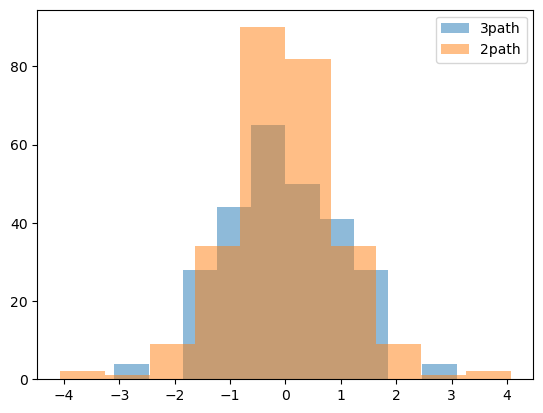

In [164]:
for k, f in {'3path': fit, '2path': fit2}.items():
    plt.hist((f.residual / f.sigma).ravel(), label=k, alpha=0.5)
plt.legend()

<Axes: >

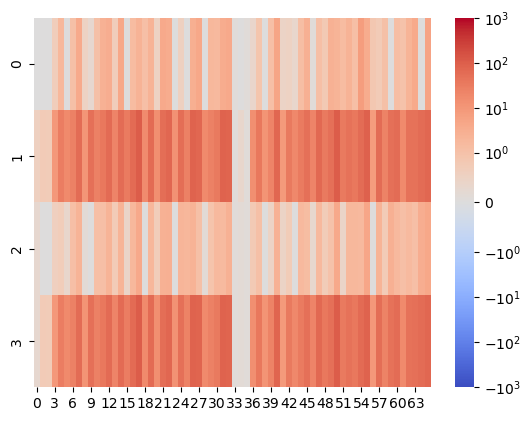

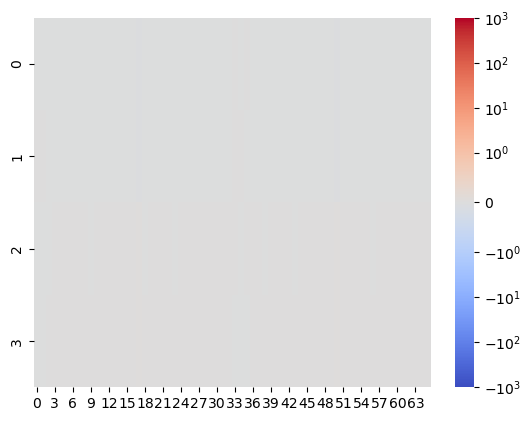

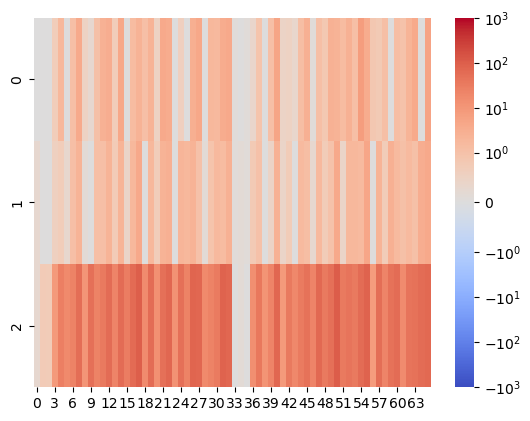

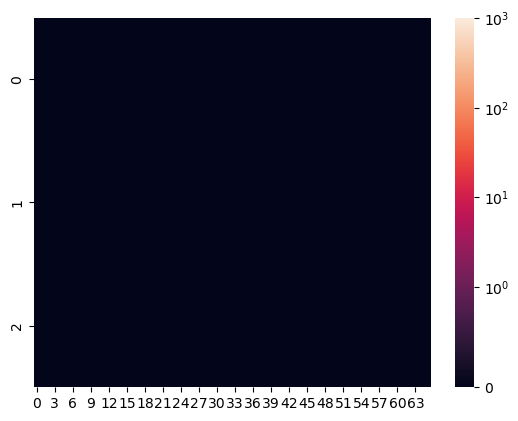

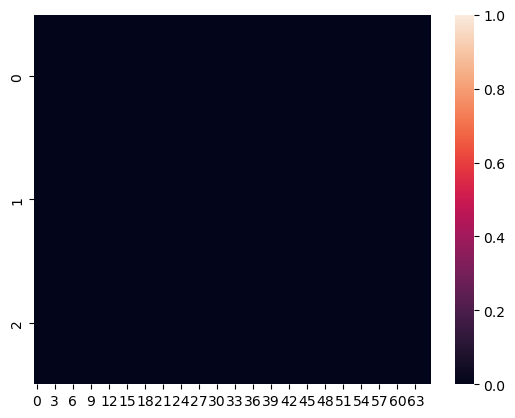

In [39]:


# _fit = sz.depth_model2.fit(fit.y, sz.deconvolution.design_paths(2, 2)[0][:, (0, 3)])
# print(_fit.score)
# fig = plt.figure()
# sns.heatmap(_fit.residual, norm=mpl.colors.SymLogNorm(1, vmin=-1e3, vmax=1e3), cmap='coolwarm')

# _fit = sz.depth_model.fit(fit.y, sz.deconvolution.design_paths(2, 2)[0][:,(0, 3)], alpha=1.0)
# print(_fit.score)
# fig = plt.figure()
# sns.heatmap(_fit.residual, norm=mpl.colors.SymLogNorm(1, vmin=-1e2, vmax=1e2), cmap='coolwarm')

# _fit = sz.depth_model.fit(fit.y, sz.deconvolution.design_paths(2, 2)[0][:,(1, 2)], alpha=1.0)
# print(_fit.score)
# fig = plt.figure()
# sns.heatmap(_fit.residual, norm=mpl.colors.SymLogNorm(1, vmin=-1e2, vmax=1e2), cmap='coolwarm')

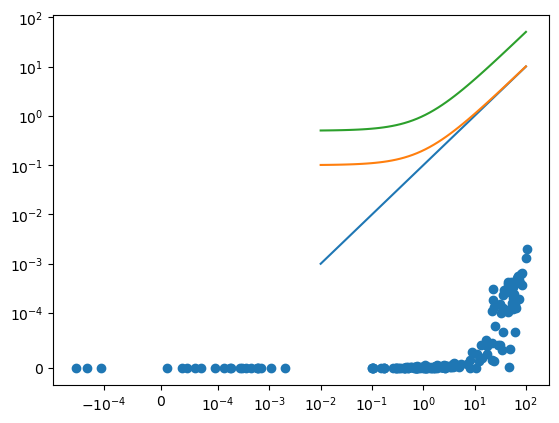

In [36]:
plt.scatter(fit.beta, stderr)
xx = np.logspace(-2, 2)
plt.plot(xx, xx * 0.1)
plt.plot(xx, (xx + 1) * 0.1)
plt.plot(xx, (xx + 1) * 0.5)
plt.yscale('symlog', linthresh=1e-4)
plt.xscale('symlog', linthresh=1e-4)